In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
ifmha = pd.read_csv('./tauraat-230322-150349.csv', converters={'site_no': str}, low_memory=False)

In [3]:
us = gpd.read_file('./data/us_shpfile/s_08mr23.shp')

In [4]:
df = ifmha['site_no'].value_counts().to_frame()

In [5]:
df.head()

,site_no
06807000,6580
06486000,5477
06610000,5455
07022000,3100
06601200,2992


In [6]:
df['latitude'] = ifmha.drop_duplicates(subset='site_no', keep='first').set_index('site_no')['dec_lat_va']
df['longitude'] = ifmha.drop_duplicates(subset='site_no', keep='first').set_index('site_no')['dec_long_va']

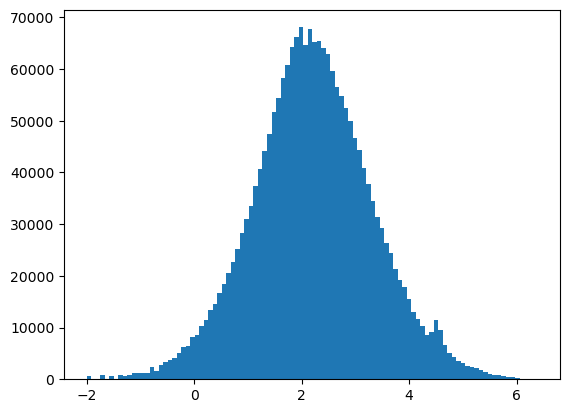

In [7]:
fig, ax = plt.subplots()
ax.hist(np.log10(ifmha['chan_discharge']), bins=100)
plt.show()

In [8]:
df['discharge'] = ifmha.groupby('site_no').apply(lambda x: x['chan_discharge'].median())

In [9]:
df.reset_index(inplace=True)

In [10]:
# Convert ft to meter
df['discharge'] = 0.028316832 * df['discharge']

In [14]:
df.rename(columns={'index': 'site_no', 'site_no': 'site_count'}, inplace=True)
df.head()

,site_count,site_count,latitude,longitude,discharge,count_cat,discharge_scale
0,06807000,6580,40.681946,-95.846946,1050.554467,6.0,260.0
1,06486000,5477,42.485828,-96.413918,900.475258,6.0,170.0
2,06610000,5455,41.258887,-95.922514,940.118822,6.0,170.0
3,07022000,3100,37.221600,-89.462975,5493.465408,6.0,370.0
4,06601200,2992,42.007210,-96.241688,886.316842,6.0,170.0


In [18]:
df.to_csv('./data/choropleth_map.csv', sep=',', encoding='utf-8', index=False)

In [ ]:
bins=[50, 100, 250, 500, 1000, 2500, 6580]

for idx, count in enumerate(bins):
    if idx == len(bins)-1:
        continue
    df.loc[(df['site_count'] >= count) & (df['site_count'] <= bins[idx+1]),'count_cat' ] = idx+1

# 10 * (1 + idx**2)

In [19]:
bins=[0, 10, 50, 100, 500, 1000, 2000, 60000]

for idx, dis in enumerate(bins):
    if idx == len(bins)-1:
        continue
    df.loc[(df['discharge'] >= dis) & (df['discharge'] < bins[idx+1]),'discharge_scale' ] = 10 * (1 + idx**2)

In [18]:
df['count_cat'] = df['count_cat'].astype(int)
df['count_cat'].value_counts()

3    2330
2    2319
4     927
1     807
5     108
6       7
Name: count_cat, dtype: int64

In [53]:
# bins=[0, 10, 50, 100, 500, 1000, 2000, 60000]
bins=[50, 100, 250, 500, 1000, 2500, 6580]
np.histogram(df['site_count'], bins=bins)

(array([ 807, 2319, 2330,  927,  108,    7], dtype=int64),
 array([  50,  100,  250,  500, 1000, 2500, 6580]))

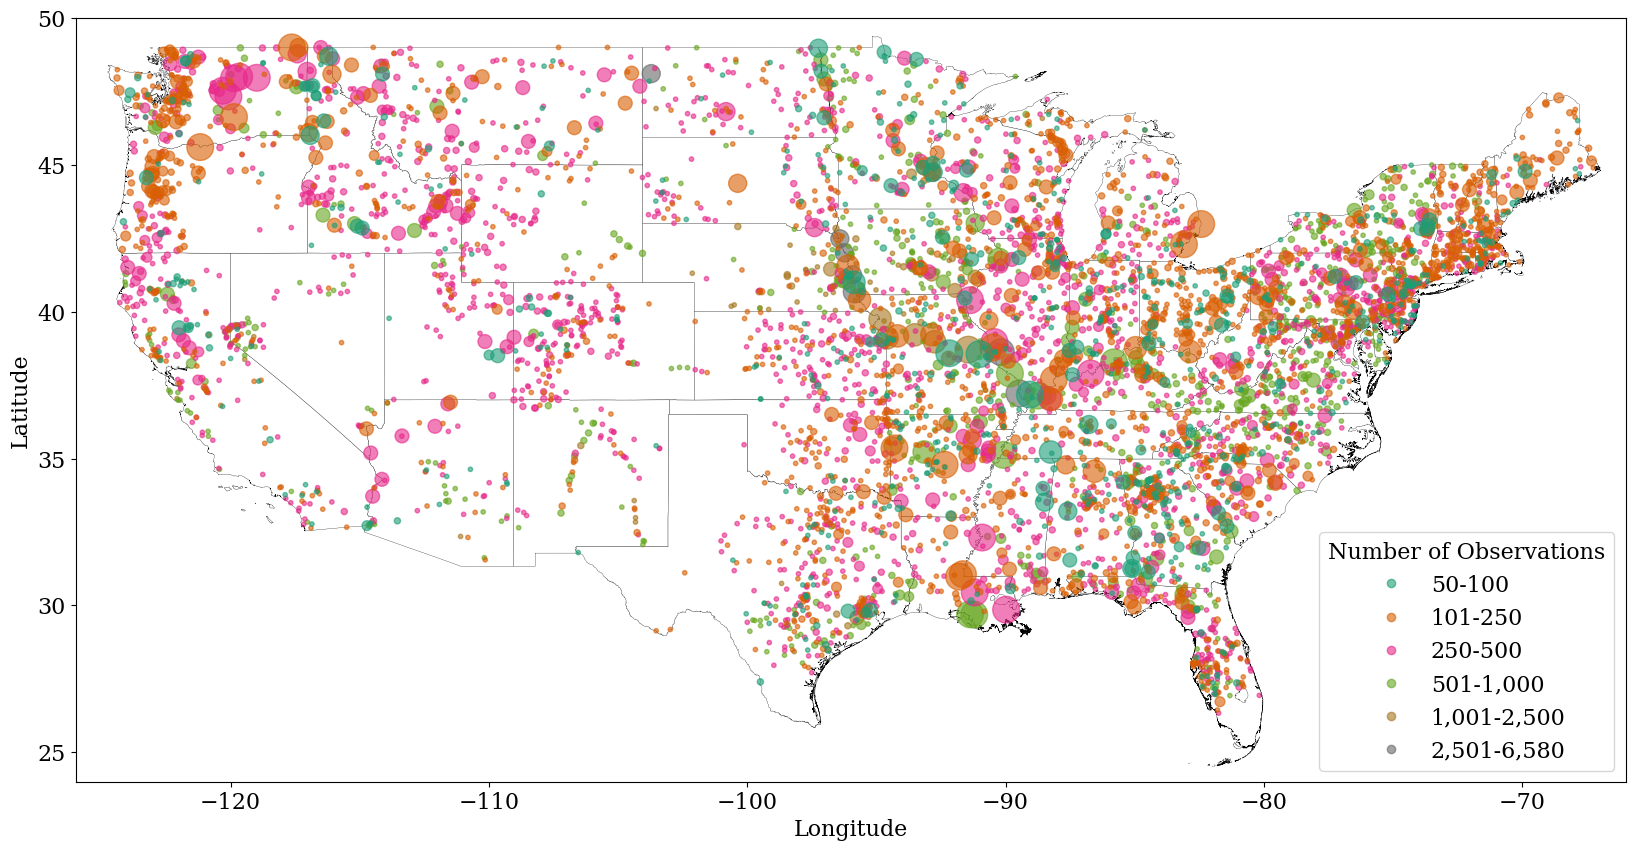

In [35]:
from matplotlib import colors
plt.rcParams.update({
    # 'font.sans-serif': 'Comic Sans MS',
    'font.family': 'serif',
    'font.size': 16
})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
us.plot(ax=ax, color='#ffffff', edgecolor='#000000', linewidth=0.2)

cmap=plt.cm.get_cmap('RdYlBu').reversed()
# sc = ax.scatter(df['longitude'], df['latitude'], s=df['discharge_scale'], c=df['site_no'], alpha=0.6, cmap='tab20c', norm=colors.LogNorm())
sc = ax.scatter(df['longitude'], df['latitude'], s=df['discharge_scale'], c=df['count_cat'],  alpha=0.6, cmap='Dark2')
ax.set_xlim([-126, -66])
ax.set_ylim([24, 50])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')


# ax.grid(False)
# cbar = plt.colorbar(sc, pad=0.01, shrink=0.42)
# cbar.set_label('Number of Measurements', fontsize=14, labelpad=15)
#
handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
#
labels=['50-100', '101-250', '250-500', '501-1,000', '1,001-2,500', '2,501-6,580']

#
legend2 = ax.legend(handles, labels, loc="lower right", title=rf"Number of Observations")
#
f = 'pdf'
plt.savefig(f'./choropleth-scale.{f}', format=f'{f}', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [40]:
us_albers = us.to_crs(epsg=5071)

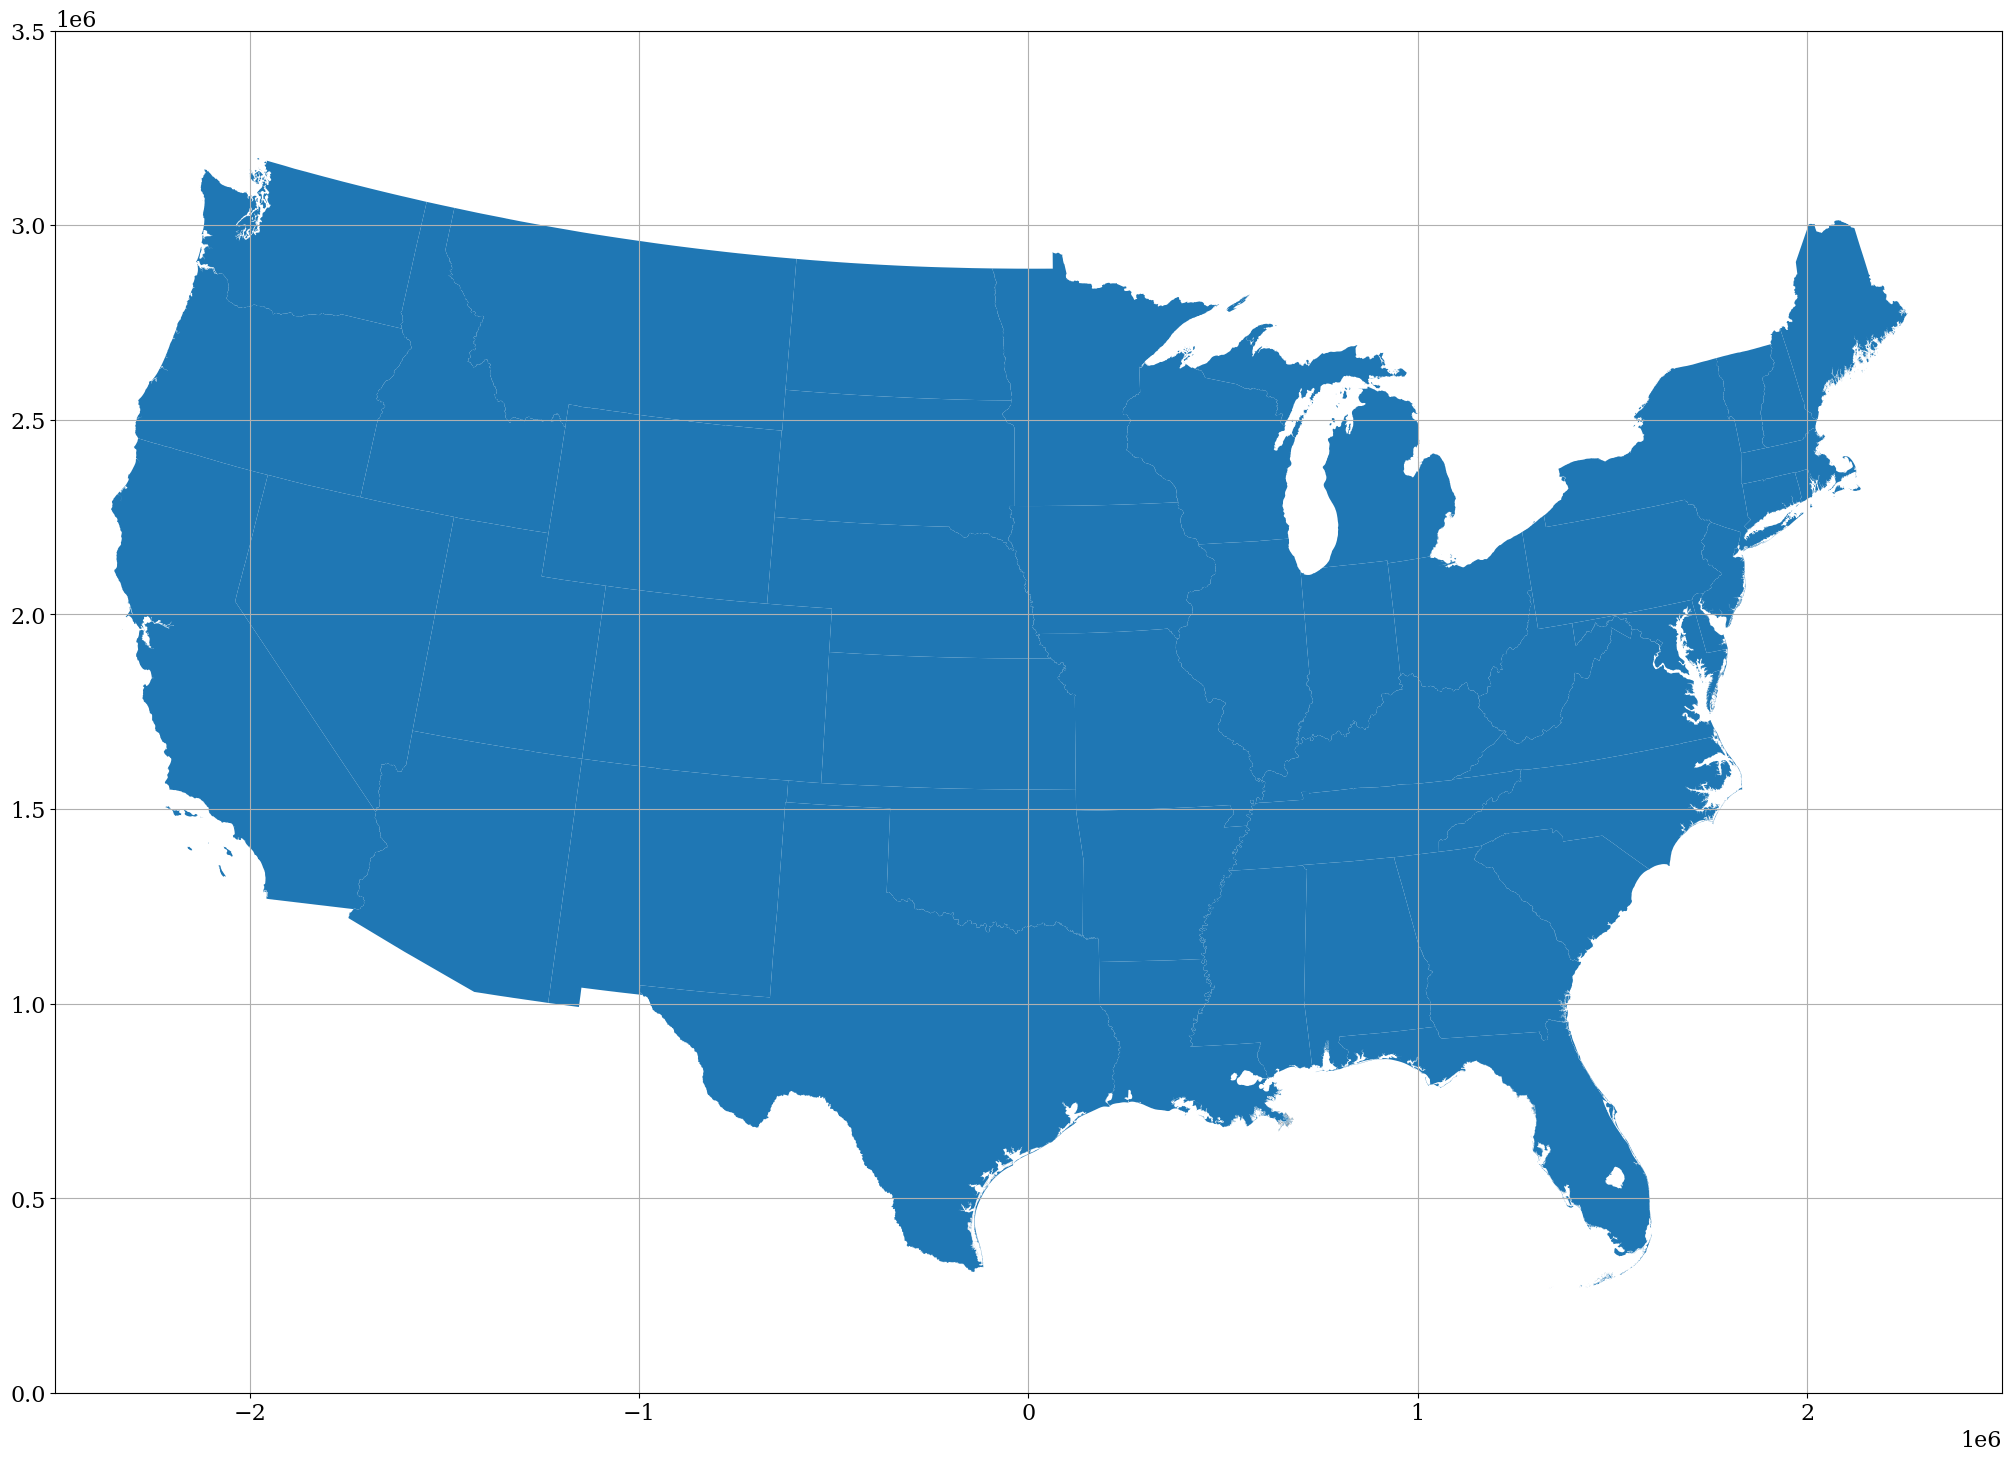

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20), constrained_layout=True)

us_albers.plot(ax=ax, legend=True)
ax.set_xlim([-2.5E6, 2.5E6])
ax.set_ylim([0E6, 3.5E6])


plt.grid(True)
plt.show()